<a href="https://colab.research.google.com/github/Wannisa030/MY_Project/blob/main/rov_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ขั้นตอนการสกัดข้อความด้วย optical character recognition (OCR)


เชื่อมต่อ Colad กับ Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


ติดตั้ง pytesseract

In [2]:
!pip install pytesseract
!pip install numpy
!pip install opencv-python
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y tesseract-ocr-tha  # ภาษาไทย
!apt-get install -y tesseract-ocr-jpn  # ภาษาญี่ปุ่น
!apt-get install -y tesseract-ocr-chi-sim  # ภาษาจีน (ตัวย่อ)
!apt-get install -y tesseract-ocr-kor  # ภาษาเกาหลี
!apt-get install -y tesseract-ocr-eng  # ภาษาอังกฤษ
!apt-get install -y tesseract-ocr-fra  # ภาษาฝรั่งเศส


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [457 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,235 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [49.9 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,103 kB]
Hit:13 https:/

import module

In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import pandas as pd
import pytesseract
import re
import requests
import os

กำหนดเส้นทางเข้าถึงไฟล์รูป

In [4]:
rootPath = '/content/drive/MyDrive/Gamerov/'

# Funtion

In [5]:
# เปลี่ยน file เป็น IMG
def origin(file):
    img = cv2.imdecode(np.fromstring(file.read(), np.uint8), cv2.IMREAD_COLOR)
    return img

dash_detail

1. กรองสีฟ้า
2. กรองสีเเดง
3. นำ 2 ภาพมารวมกัน
4. ทำให้ภาพให้อยู่สีตรงข้าม ุ
5. เกลี่ย noise ภาพให้ ข้อความชัดขึ้น

In [6]:
# filter details
def dash_details(img):
    #filter blue
    img_color_extract_blue = cv2.inRange(img,np.array([122,0,0]), np.array([255,255,255]))
    #filter red
    img_color_extract_red = cv2.inRange(img,np.array([0,0,127]), np.array([255,255,255]))
    # mix 2 filter
    merge_img = cv2.addWeighted(img_color_extract_blue ,0.6,img_color_extract_red,0.6,1)
    # invert
    diff_img = cv2.bitwise_not(merge_img)
    # filter Noise
    pre_img_result = cv2.adaptiveThreshold(diff_img,255 ,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,50)
    return pre_img_result

dash_statistics

1. กรองสีฟ้า
2. กรองสีเเดง
3. นำ 2 ภาพมารวมกัน
4. ทำให้ภาพให้อยู่สีตรงข้าม
5. กำหนด filter ที่เอาไว้ใช้กรอง
6. กรองรูปทำให้ font ใหญ่ขึ้น
7. เกลี่ย noise ภาพให้ ข้อความชัดขึ้น

In [7]:
# filter statistics
def dash_statistics(img):
    #filter blue
    img_color_extract_blue = cv2.inRange(img,np.array([127,0,0]), np.array([255,255,255]))
    #filter red
    img_color_extract_red = cv2.inRange(img,np.array([0,0,127]), np.array([255,255,255]))
    # mix 2 filter
    merge_img = cv2.addWeighted(img_color_extract_blue, 0.75, img_color_extract_red, 0.75, 1)
    # invert
    diff_img = cv2.bitwise_not(merge_img)
    #create kernel clear noise
    kernel_clear_noise = cv2.getStructuringElement(cv2.MORPH_RECT,(1,1))
    #erode to dark the font
    diff_img_font_bigger = cv2.erode(diff_img, kernel_clear_noise)
    #dark the img
    _, pre_img_result = cv2.threshold(diff_img_font_bigger,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return pre_img_result

กรองข้อความให้อยู่ใน format ที่กำหนด
ก็จะมี กรอง ชื่อ, กรอง ตัวเลขที่มีทั้งจำนวนเต็มและทศนิยม

In [8]:
# filter cleaning text
def cleaning_text(text,step,groups,teamA,teamB):
    # กรณีชื่อ
    if step == 0:
        # case player
        result_cleaning = None
        #filter text and number lang thai,japan,china,kao,eng ,france
        filter_text = re.findall("[a-zA-Z\u3040-\u30ff\u3400-\u4dbf\u4e00-\u9fff\uf900-\ufaff\uff66-\uff9fก-๙\d._]+", text)
        #Check the text and combine the text into a sentence.
        if len(filter_text)>1:
            result_cleaning = ''.join(filter_text)
        else:
            if len(filter_text) == 0:
                result_cleaning = ''
            else:
                result_cleaning = filter_text[0]
        #เช็คและจัดการ แบ่งเป็นทีม A,B
        if(groups <= 4):
            for index, key in enumerate(teamA):
                if index == step:
                    teamA[key].append(result_cleaning)
        else:
            for index, key in enumerate(teamA):
                if index == step:
                    teamB[key].append(result_cleaning)

    #กรณีที่เป็นเลขจำนวนเต็ม
    elif step > 0 and step < 5 or step in [6,8,10]:
        # filter int number
        result_cleaning = re.findall("\d+",text)
        if len(result_cleaning) > 0:
            result_cleaning = result_cleaning[0]
            #เช็คและจัดการ แบ่งเป็นทีม A,B
            if(groups <= 4):
                for index,key in enumerate(teamA):
                    if index == step:
                        teamA[key].append(result_cleaning)
            else:
                for index, key in enumerate(teamA):
                    if index == step:
                        teamB[key].append(result_cleaning)
        else:
            if(groups <= 4):
                for index, key in enumerate(teamA):
                    if index == step:
                        teamA[key].append('')
            else:
                for index, key in enumerate(teamA):
                    if index == step:
                        teamB[key].append('')

    # กรณีเลขทศนิยม
    else:
        cleaning_text_result = re.findall("[\d+\%]",text)
        result_cleaning = ''
        # ถ้าในข้อความนั้นไม่มี % ให้เพิ่ม % เข้าไป
        if '%' not in cleaning_text_result and len(cleaning_text_result) > 0:
            cleaning_text_result.append('%')
        else:
            for index, value in enumerate(cleaning_text_result):
                if value == '%' and index+1 != len(cleaning_text_result):
                    cleaning_text_result.pop(index)
                    cleaning_text_result.append('%')
        # เช็คตัวเลขที่มีจำนวนมากกว่า 4 ให้ลบ
        if len(cleaning_text_result) > 4:
            cleaning_text_result.pop(0)
        # ใส่จุดทศนิยม
        if(len(cleaning_text_result) > 0):
            cleaning_text_result.insert(-2,".")
            pure_text = ''.join(cleaning_text_result[:-1:])
            try:
                result_cleaning = float(pure_text)
            except ValueError:
                result_cleaning = 0.0
        else:
            result_cleaning = 0.0
        #เช็คและจัดการ แบ่งเป็นทีม A,B
        if(groups <= 4):
            for index, key in enumerate(teamA):
                if index == step:
                    teamA[key].append(result_cleaning)
        else:
            for index, key in enumerate(teamA):
                if index == step:
                    teamB[key].append(result_cleaning)


ฟังก์ชั่น หาค่า cer

In [9]:
# Function สำหรับคำนวณ Character Error Rate (CER)
def character_error_rate(ground_truth, predicted_text):
    len_ground_truth = len(ground_truth)
    len_predicted = len(predicted_text)

    # กรณีที่ ground_truth หรือ predicted_text เป็นสตริงว่าง
    if len_ground_truth == 0:
        return 0.0
    if len_predicted == 0:
        return 1.0

    # สร้างเมตริกซ์ dp สำหรับเก็บค่า dynamic programming
    dp = [[0] * (len_predicted + 1) for _ in range(len_ground_truth + 1)]

    # คำนวณค่า CER ด้วย Dynamic Time Warping
    for i in range(len_ground_truth + 1):
        for j in range(len_predicted + 1):
            if i == 0:
                dp[i][j] = j
            elif j == 0:
                dp[i][j] = i
            elif ground_truth[i - 1] == predicted_text[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])

    # คืนค่า CER ที่เป็นเปอร์เซ็นต์
    return dp[len_ground_truth][len_predicted] / len_ground_truth

# ระบุตำแหน่งรูปที่ต้องการทำ OCR เพื่อง่ายต่อการสกัดข้อความ

In [10]:
# # solution for find roi of image
# img_file_details = 'Screenshot_2021-07-17-10-54-17-40_d0bf58d7ec12abbe46776ffc839333b7.jpg'
# img_path_details = os.path.join(rootPath, img_file_details)
# # ------------เลือกตำปหน่งของภาพ---------------------
# r = cv2.selectROI("เลือกพื้นที่ที่คุณต้องการ (select the area)",img_path_details)
# # ตัดภาพ
# crop_img = img_path_details[int(r[1]) : int(r[1]+r[3]),
#                             int(r[0]) : int(r[0])+r[2]]
# # แสดงค่าที่ตัดมา
# print(f'       "height": {int(r[1])},\n       "heightTo": {int(r[1]+r[3])},\n       "width": {int(r[0])},\n       "widthTo": {int(r[0]+r[2])},\n ')

# cv2.imshow('Result',crop_img)
# cv2.waitKey(0)

In [11]:
# Specify the position of the image to be OCR.
specify_image = {
        "Player01":{
            "name":{
                "height": 144,
                "heightTo": 178,
                "width": 195,
                "widthTo": 331,
            },
            "kill":{
                "height": 144,
                "heightTo": 178,
                "width": 328,
                "widthTo": 362,
            },
            "dead":{
                "height": 144,
                "heightTo": 178,
                "width": 363,
                "widthTo": 403,
            },
            "assist":{
                "height": 144,
                "heightTo": 178,
                "width": 401,
                "widthTo": 439,
            },
            "money":{
                "height": 144,
                "heightTo": 178,
                "width": 439,
                "widthTo": 500,
            },
            "point":{
                "height": 144,
                "heightTo": 178,
                "width": 499,
                "widthTo": 542,
            },
            "damage":{
                "height": 152,
                "heightTo": 168,
                "width": 325,
                "widthTo": 403,
            },
            "damage_p":{
                "height": 169,
                "heightTo": 186,
                "width": 325,
                "widthTo": 403,
            },
            "take_damage":{
                "height": 152,
                "heightTo": 168,
                "width": 409,
                "widthTo": 494,
            },
            "take_damage_p":{
                "height": 169,
                "heightTo": 186,
                "width": 409,
                "widthTo": 494,
            },
            "team_fight":{
                "height": 152,
                "heightTo": 168,
                "width": 505,
                "widthTo": 594,
            },
            "team_fight_p":{
                "height": 169,
                "heightTo": 186,
                "width": 505,
                "widthTo": 594,
            },
        },
        "Player02":{
            "name":{
                "height": 214,
                "heightTo": 245,
                "width": 195,
                "widthTo": 331,
            },
            "kill":{
                "height": 214,
                "heightTo": 245,
                "width": 328,
                "widthTo": 362,
            },
            "dead":{
                "height": 214,
                "heightTo": 245,
                "width": 363,
                "widthTo": 403,
            },
            "assist":{
                "height": 214,
                "heightTo": 245,
                "width": 401,
                "widthTo": 439,
            },
            "money":{
                "height": 214,
                "heightTo": 245,
                "width": 439,
                "widthTo": 500,
            },
            "point":{
                "height": 214,
                "heightTo": 245,
                "width": 499,
                "widthTo": 542,
            },
            "damage":{
                "height": 220,
                "heightTo": 241,
                "width": 325,
                "widthTo": 403,
            },
            "damage_p":{
                "height": 238,
                "heightTo": 258,
                "width": 325,
                "widthTo": 403,
            },
            "take_damage":{
                "height": 220,
                "heightTo": 241,
                "width": 409,
                "widthTo": 494,
            },
            "take_damage_p":{
                "height": 238,
                "heightTo": 258,
                "width": 409,
                "widthTo": 494,
            },
            "team_fight":{
                "height": 220,
                "heightTo": 241,
                "width": 505,
                "widthTo": 594,
            },
            "team_fight_p":{
                "height": 238,
                "heightTo": 258,
                "width": 505,
                "widthTo": 594,
            },
        },
        "Player03":{
            "name":{
                "height": 285,
                "heightTo": 317,
                "width": 195,
                "widthTo": 331,
            },
            "kill":{
                "height": 285,
                "heightTo": 317,
                "width": 328,
                "widthTo": 362,
            },
            "dead":{
                "height": 285,
                "heightTo": 317,
                "width": 363,
                "widthTo": 403,
            },
            "assist":{
                "height": 285,
                "heightTo": 317,
                "width": 401,
                "widthTo": 439,
            },
            "money":{
                "height": 285,
                "heightTo": 317,
                "width": 439,
                "widthTo": 500,
            },
            "point":{
                "height": 285,
                "heightTo": 317,
                "width": 499,
                "widthTo": 542,
            },
            "damage":{
                "height": 289,
                "heightTo": 312,
                "width": 325,
                "widthTo": 403,
            },
            "damage_p":{
                "height": 311,
                "heightTo": 327,
                "width": 325,
                "widthTo": 403,
            },
            "take_damage":{
                "height": 289,
                "heightTo": 312,
                "width": 409,
                "widthTo": 494,
            },
            "take_damage_p":{
                "height": 311,
                "heightTo": 327,
                "width": 409,
                "widthTo": 494,
            },
            "team_fight":{
                "height": 289,
                "heightTo": 312,
                "width": 505,
                "widthTo": 594,
            },
            "team_fight_p":{
                "height": 311,
                "heightTo": 327,
                "width": 505,
                "widthTo": 594,
            },
        },
        "Player04":{
            "name":{
                "height": 356,
                "heightTo": 385,
                "width": 195,
                "widthTo": 331,
            },
            "kill":{
                "height": 356,
                "heightTo": 385,
                "width": 328,
                "widthTo": 362,
            },
            "dead":{
                "height": 356,
                "heightTo": 385,
                "width": 363,
                "widthTo": 403,
            },
            "assist":{
                "height": 356,
                "heightTo": 385,
                "width": 401,
                "widthTo": 439,
            },
            "money":{
                "height": 356,
                "heightTo": 385,
                "width": 439,
                "widthTo": 500,
            },
            "point":{
                "height": 356,
                "heightTo": 385,
                "width": 499,
                "widthTo": 542,
            },
            "damage":{
                "height": 360,
                "heightTo": 381,
                "width": 325,
                "widthTo": 403,
            },
            "damage_p":{
                "height": 381,
                "heightTo": 395,
                "width": 325,
                "widthTo": 403,
            },
            "take_damage":{
                "height": 360,
                "heightTo": 381,
                "width": 409,
                "widthTo": 494,
            },
            "take_damage_p":{
                "height": 381,
                "heightTo": 395,
                "width": 409,
                "widthTo": 494,
            },
            "team_fight":{
                "height": 360,
                "heightTo": 381,
                "width": 505,
                "widthTo": 594,
            },
            "team_fight_p":{
                "height": 381,
                "heightTo": 395,
                "width": 505,
                "widthTo": 594,
            },
        },
        "Player05":{
            "name":{
                "height": 426,
                "heightTo": 456,
                "width": 195,
                "widthTo": 331,
            },
            "kill":{
                "height": 426,
                "heightTo": 456,
                "width": 328,
                "widthTo": 362,
            },
            "dead":{
                "height": 426,
                "heightTo": 456,
                "width": 363,
                "widthTo": 403,
            },
            "assist":{
                "height": 426,
                "heightTo": 456,
                "width": 401,
                "widthTo": 439,
            },
            "money":{
                "height": 426,
                "heightTo": 456,
                "width": 439,
                "widthTo": 500,
            },
            "point":{
                "height": 426,
                "heightTo": 456,
                "width": 499,
                "widthTo": 542,
            },
            "damage":{
                "height": 431,
                "heightTo": 452,
                "width": 325,
                "widthTo": 403,
            },
            "damage_p":{
                "height": 448,
                "heightTo": 467,
                "width": 325,
                "widthTo": 403,
            },
            "take_damage":{
                "height": 431,
                "heightTo": 452,
                "width": 409,
                "widthTo": 494,
            },
            "take_damage_p":{
                "height": 448,
                "heightTo": 467,
                "width": 409,
                "widthTo": 494,
            },
            "team_fight":{
                "height": 431,
                "heightTo": 452,
                "width": 505,
                "widthTo": 594,
            },
            "team_fight_p":{
                "height": 448,
                "heightTo": 467,
                "width": 505,
                "widthTo": 594,
            },
        },
        "Player06":{
            "name":{
                "height": 144,
                "heightTo": 178,
                "width": 667,
                "widthTo": 798,
            },
            "kill":{
                "height": 144,
                "heightTo": 178,
                "width": 801,
                "widthTo": 836,
            },
            "dead":{
                "height": 144,
                "heightTo": 178,
                "width": 838,
                "widthTo": 872,
            },
            "assist":{
                "height": 144,
                "heightTo": 178,
                "width": 874,
                "widthTo": 907,
            },
            "money":{
                "height": 144,
                "heightTo": 178,
                "width": 905,
                "widthTo": 969,
            },
            "point":{
                "height": 144,
                "heightTo": 178,
                "width": 970,
                "widthTo": 1013,
            },
            "damage":{
                "height": 152,
                "heightTo": 168,
                "width": 794,
                "widthTo": 871,
            },
            "damage_p":{
                "height": 169,
                "heightTo": 186,
                "width": 794,
                "widthTo": 871,
            },
            "take_damage":{
                "height": 152,
                "heightTo": 168,
                "width": 881,
                "widthTo": 963,
            },
            "take_damage_p":{
                "height": 169,
                "heightTo": 186,
                "width": 881,
                "widthTo": 963,
            },
            "team_fight":{
                "height": 152,
                "heightTo": 168,
                "width": 975,
                "widthTo": 1059,
            },
            "team_fight_p":{
                "height": 169,
                "heightTo": 186,
                "width": 975,
                "widthTo": 1059,
            },
        },
        "Player07":{
            "name":{
                "height": 214,
                "heightTo": 245,
                "width": 667,
                "widthTo": 798,
            },
            "kill":{
                "height": 214,
                "heightTo": 245,
                "width": 801,
                "widthTo": 836,
            },
            "dead":{
                "height": 214,
                "heightTo": 245,
                "width": 838,
                "widthTo": 872,
            },
            "assist":{
                "height": 214,
                "heightTo": 245,
                "width": 874,
                "widthTo": 907,
            },
            "money":{
                "height": 214,
                "heightTo": 245,
                "width": 905,
                "widthTo": 969,
            },
            "point":{
                "height": 214,
                "heightTo": 245,
                "width": 970,
                "widthTo": 1013,
            },
            "damage":{
                "height": 220,
                "heightTo": 241,
                "width": 794,
                "widthTo": 871,
            },
            "damage_p":{
                "height": 238,
                "heightTo": 258,
                "width": 794,
                "widthTo": 871,
            },
            "take_damage":{
                "height": 220,
                "heightTo": 241,
                "width": 881,
                "widthTo": 963,
            },
            "take_damage_p":{
                "height": 238,
                "heightTo": 258,
                "width": 881,
                "widthTo": 963,
            },
            "team_fight":{
                "height": 220,
                "heightTo": 241,
                "width": 975,
                "widthTo": 1059,
            },
            "team_fight_p":{
                "height": 238,
                "heightTo": 258,
                "width": 975,
                "widthTo": 1059,
            },
        },
        "Player08":{
            "name":{
                "height": 285,
                "heightTo": 317,
                "width": 667,
                "widthTo": 798,
            },
            "kill":{
                "height": 285,
                "heightTo": 317,
                "width": 801,
                "widthTo": 836,
            },
            "dead":{
                "height": 285,
                "heightTo": 317,
                "width": 838,
                "widthTo": 872,
            },
            "assist":{
                "height": 285,
                "heightTo": 317,
                "width": 874,
                "widthTo": 907,
            },
            "money":{
                "height": 285,
                "heightTo": 317,
                "width": 905,
                "widthTo": 969,
            },
            "point":{
                "height": 285,
                "heightTo": 317,
                "width": 970,
                "widthTo": 1013,
            },
            "damage":{
                "height": 289,
                "heightTo": 312,
                "width": 794,
                "widthTo": 871,
            },
            "damage_p":{
                "height": 311,
                "heightTo": 327,
                "width": 794,
                "widthTo": 871,
            },
            "take_damage":{
                "height": 289,
                "heightTo": 312,
                "width": 881,
                "widthTo": 963,
            },
            "take_damage_p":{
                "height": 311,
                "heightTo": 327,
                "width": 881,
                "widthTo": 963,
            },
            "team_fight":{
                "height": 289,
                "heightTo": 312,
                "width": 975,
                "widthTo": 1059,
            },
            "team_fight_p":{
                "height": 311,
                "heightTo": 327,
                "width": 975,
                "widthTo": 1059,
            },
        },
        "Player09":{
            "name":{
                "height": 356,
                "heightTo": 385,
                "width": 667,
                "widthTo": 798,
            },
            "kill":{
                "height": 356,
                "heightTo": 385,
                "width": 801,
                "widthTo": 836,
            },
            "dead":{
                "height": 356,
                "heightTo": 385,
                "width": 838,
                "widthTo": 872,
            },
            "assist":{
                "height": 356,
                "heightTo": 385,
                "width": 874,
                "widthTo": 907,
            },
            "money":{
                "height": 356,
                "heightTo": 385,
                "width": 905,
                "widthTo": 969,
            },
            "point":{
                "height": 356,
                "heightTo": 385,
                "width": 970,
                "widthTo": 1013,
            },
            "damage":{
                "height": 360,
                "heightTo": 381,
                "width": 794,
                "widthTo": 871,
            },
            "damage_p":{
                "height": 381,
                "heightTo": 395,
                "width": 794,
                "widthTo": 871,
            },
            "take_damage":{
                "height": 360,
                "heightTo": 381,
                "width": 881,
                "widthTo": 963,
            },
            "take_damage_p":{
                "height": 381,
                "heightTo": 395,
                "width": 881,
                "widthTo": 963,
            },
            "team_fight":{
                "height": 360,
                "heightTo": 381,
                "width": 975,
                "widthTo": 1059,
            },
            "team_fight_p":{
                "height": 381,
                "heightTo": 395,
                "width": 975,
                "widthTo": 1059,
            },
        },
        "Player10":{
            "name":{
                "height": 426,
                "heightTo": 456,
                "width": 667,
                "widthTo": 798,
            },
            "kill":{
                "height": 426,
                "heightTo": 456,
                "width": 801,
                "widthTo": 836,
            },
            "dead":{
                "height": 426,
                "heightTo": 456,
                "width": 838,
                "widthTo": 872,
            },
            "assist":{
                "height": 426,
                "heightTo": 456,
                "width": 874,
                "widthTo": 907,
            },
            "money":{
                "height": 426,
                "heightTo": 456,
                "width": 905,
                "widthTo": 969,
            },
            "point":{
                "height": 426,
                "heightTo": 456,
                "width": 970,
                "widthTo": 1013,
            },
            "damage":{
                "height": 431,
                "heightTo": 452,
                "width": 794,
                "widthTo": 871,
            },
            "damage_p":{
                "height": 448,
                "heightTo": 467,
                "width": 794,
                "widthTo": 871,
            },
            "take_damage":{
                "height": 431,
                "heightTo": 452,
                "width": 881,
                "widthTo": 963,
            },
            "take_damage_p":{
                "height": 448,
                "heightTo": 467,
                "width": 881,
                "widthTo": 963,
            },
            "team_fight":{
                "height": 431,
                "heightTo": 452,
                "width": 975,
                "widthTo": 1059,
            },
            "team_fight_p":{
                "height": 448,
                "heightTo": 467,
                "width": 975,
                "widthTo": 1059,
            },
        },
    }

# ปรับแต่งภาพ ก่อนทำ OCR เพื่อเพิ่มประสิทธิภาพในการสกัดข้อความ

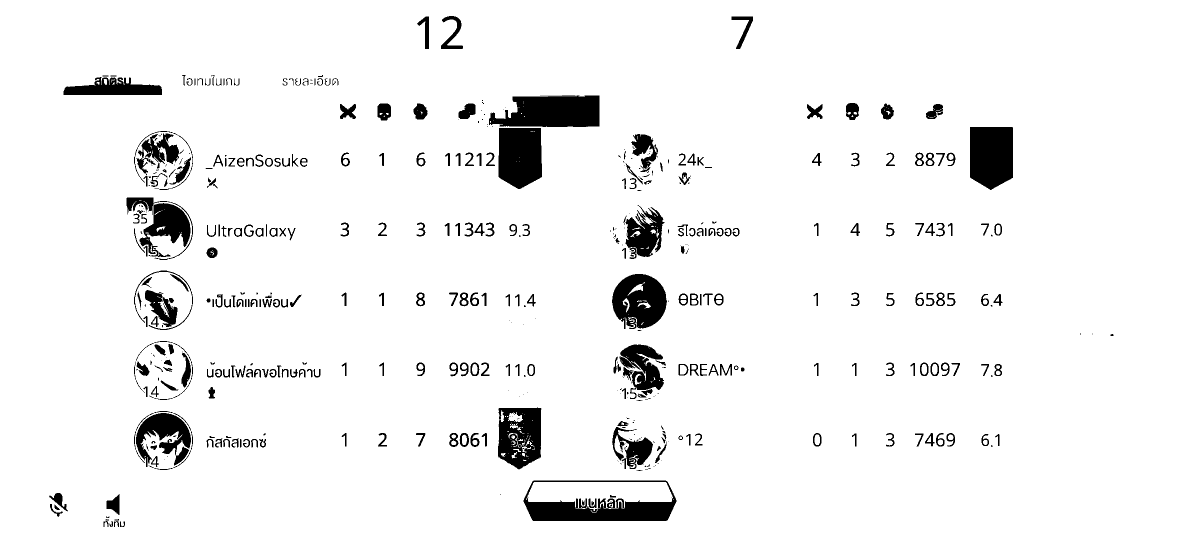

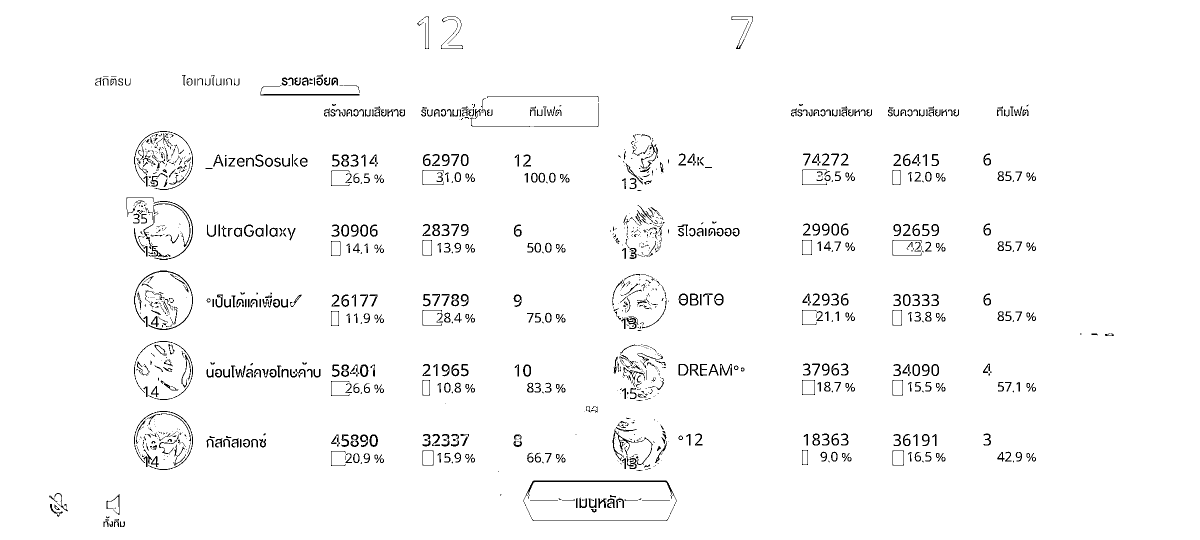

In [12]:
# อ่านรูปภาพจากโฟลเดอร์ที่กำหนดโดย rootPath
img_file_details = 'Screenshot_2021-07-17-10-54-17-40_d0bf58d7ec12abbe46776ffc839333b7.jpg'
img_path_details = os.path.join(rootPath, img_file_details)
img_file_statistic = 'Screenshot_2021-07-17-10-54-13-43_d0bf58d7ec12abbe46776ffc839333b7.jpg'
img_path_statistic = os.path.join(rootPath, img_file_statistic)

# แต่งภาพ
image_statistic_origin = cv2.imread(img_path_statistic, cv2.IMREAD_COLOR)
image_details_origin = cv2.imread(img_path_details, cv2.IMREAD_COLOR)
processed_statistics = dash_statistics(image_statistic_origin)
processed_details = dash_details(image_details_origin)

# ปรับขนาดภาพ
scale_percent = 50
# resize statistics img
width_img_processed_statistics = int(processed_statistics.shape[1] * scale_percent / 100)
height_img_processed_statistics = int(processed_statistics.shape[0] * scale_percent / 100)
dsize_img_processed_statistics = (width_img_processed_statistics, height_img_processed_statistics)
imgsize_img_processed_statistics = cv2.resize(processed_statistics,dsize_img_processed_statistics)
# resize details img
width_img_processed_details = int(processed_details.shape[1] * scale_percent / 100)
height_img_processed_details = int(processed_details.shape[0] * scale_percent / 100)
dsize_img_processed_details = (width_img_processed_details, height_img_processed_details)
imgsize_img_processed_details = cv2.resize(processed_details,dsize_img_processed_details)

# แสดงรูปภาพใน Colab
cv2_imshow(imgsize_img_processed_statistics)
cv2_imshow(imgsize_img_processed_details)

# สกัดข้อความด้วย pytesseract

In [13]:
# result data
result_data = {}

In [14]:
for data_index in range(2):
            teamA = {
                "name":[],
                "kill":[],
                "dead":[],
                "assist":[],
                "money":[],
                "point":[],
                "damage":[],
                "damage_p":[],
                "take_damage":[],
                "take_damage_p":[],
                "team_fight":[],
                "team_fight_p":[],
            }
            teamB = {
                "name":[],
                "kill":[],
                "dead":[],
                "assist":[],
                "money":[],
                "point":[],
                "damage":[],
                "damage_p":[],
                "take_damage":[],
                "take_damage_p":[],
                "team_fight":[],
                "team_fight_p":[],
            }
            for index_player ,key in enumerate(specify_image):
                if index_player <= 4:
                    # case team blue
                    for index_point ,name in enumerate(specify_image[key]):
                        if index_point <= 5:
                            # img = cv2.imread(imgsize_img_processed_statistics)
                            img_specify_image = imgsize_img_processed_statistics[specify_image[key][name]['height']:specify_image[key][name]['heightTo'], specify_image[key][name]['width']:specify_image[key][name]['widthTo']]
                            result_ocr = pytesseract.image_to_string( img_specify_image, lang='eng+tha+jpn', config='--psm 6 -c preserve_interword_spaces=1' )
                            cleaning_text(result_ocr,index_point, index_player, teamA, teamB)
                        else:
                            # img = cv2.imread(imgsize_img_processed_details)
                            img_specify_image = imgsize_img_processed_details[specify_image[key][name]['height']:specify_image[key][name]['heightTo'], specify_image[key][name]['width']:specify_image[key][name]['widthTo']]
                            result_ocr = pytesseract.image_to_string( img_specify_image, lang='eng+tha+jpn', config='--psm 6 -c preserve_interword_spaces=1' )
                            cleaning_text(result_ocr,index_point, index_player, teamA, teamB)
                else:
                    # case team blue
                    for index_point ,name in enumerate(specify_image[key]):
                        if index_point <= 5:
                            # img = cv2.imread(imgsize_img_processed_statistics)
                            img_specify_image = imgsize_img_processed_statistics[specify_image[key][name]['height']:specify_image[key][name]['heightTo'], specify_image[key][name]['width']:specify_image[key][name]['widthTo']]
                            result_ocr = pytesseract.image_to_string( img_specify_image, lang='eng+tha+jpn', config='--psm 6 -c preserve_interword_spaces=1' )
                            cleaning_text(result_ocr,index_point, index_player, teamA, teamB)
                        else:
                            # img = cv2.imread(imgsize_img_processed_details)
                            img_specify_image = imgsize_img_processed_details[specify_image[key][name]['height']:specify_image[key][name]['heightTo'], specify_image[key][name]['width']:specify_image[key][name]['widthTo']]
                            result_ocr = pytesseract.image_to_string( img_specify_image, lang='eng+tha+jpn', config='--psm 6 -c preserve_interword_spaces=1' )
                            cleaning_text(result_ocr,index_point, index_player, teamA, teamB)

                #ชื่อตัวแปลแสดงข้อมูลเกี่ยวกับฟังก์ชัน
                result_data = [{"teamA": teamA},{"teamB": teamB}]
                # แสดงข้อมูลที่ทำ ocr
print(result_data)

[{'teamA': {'name': ['_AizenSosuke', 'UltraGalaxy', 'เป็นได้แค่เพื่อน', 'บ้อนไฟล์คหอโทษค้าบ', 'กัสกัสเอกซ์'], 'kill': ['6', '3', '1', '1', '1'], 'dead': ['1', '2', '1', '1', '2'], 'assist': ['6', '3', '8', '9', '7'], 'money': ['11212', '11343', '7861', '9902', '8061'], 'point': [0.0, 9.3, 11.4, 11.0, 0.0], 'damage': ['58314', '30906', '26177', '58407', '45890'], 'damage_p': [36.5, 14.1, 11.9, 26.6, 20.9], 'take_damage': ['62970', '28379', '57789', '21965', '32337'], 'take_damage_p': [31.0, 13.9, 28.4, 10.8, 15.9], 'team_fight': ['12', '6', '9', '10', ''], 'team_fight_p': [0.0, 50.0, 75.0, 83.3, 66.7]}}, {'teamB': {'name': ['24', 'จีไวล์เด้อออ', 'BITE', 'DREAM', '12'], 'kill': ['4', '1', '1', '1', '0'], 'dead': ['3', '4', '3', '1', '1'], 'assist': ['2', '5', '5', '3', '3'], 'money': ['8879', '7431', '6585', '10097', '7469'], 'point': [0.0, 7.0, 6.4, 7.8, 6.1], 'damage': ['74272', '29906', '42936', '37963', '18363'], 'damage_p': [26.5, 14.7, 0.0, 18.7, 9.0], 'take_damage': ['26415', '926

# Data

data with ocr

In [15]:
# ข้อมูลที่ได้จากการทำ ocr
data_result_data = {
    'teamA': {
        'name': ['_AizenSosuke', 'UltraGalaxy', 'เป็นได้แค่เพื่อน', 'บ้อนไฟล์คหอโทษค้าบ', 'กัสกัสเอกซ์'],
        'kill': ['6', '3', '1', '1', '1'],
        'dead': ['1', '2', '1', '1', '2'],
        'assist': ['6', '3', '8', '9', '7'],
        'money': ['11212', '11343', '7861', '9902', '8061'],
        'point': [0.0, 9.3, 11.4, 11.0, 0.0],
        'damage': ['58314', '30906', '26177', '58407', '45890'],
        'damage_p': [36.5, 14.1, 11.9, 26.6, 20.9],
        'take_damage': ['62970', '28379', '57789', '21965', '32337'],
        'take_damage_p': [31.0, 13.9, 28.4, 10.8, 15.9],
        'team_fight': ['12', '6', '9', '10', ''],
        'team_fight_p': [0.0, 50.0, 75.0, 83.3, 66.7]
    },
    'teamB': {
       'name': ['24', 'จีไวล์เด้อออ', 'BITE', 'DREAM', '12'],
       'kill': ['4', '1', '1', '1', '0'],
       'dead': ['3', '4', '3', '1', '1'],
       'assist': ['2', '5', '5', '3', '3'],
       'money': ['8879', '7431', '6585', '10097', '7469'],
       'point': [0.0, 7.0, 6.4, 7.8, 6.1],
       'damage': ['74272', '29906', '42936', '37963', '18363'],
       'damage_p': [26.5, 14.7, 0.0, 18.7, 9.0],
       'take_damage': ['26415', '92659', '30333', '34090', '36191'],
       'take_damage_p': [12.0, 22.2, 13.8, 15.5, 16.5],
       'team_fight': ['6', '6', '6', '4', '3'],
       'team_fight_p': [85.7, 85.7, 82.7, 57.1, 42.9]
    }
}

data origin

In [16]:
# ข้อมูลจริง
data_origin = {
    'teamA': {
        'name': ['_AizenSosuke', 'UltraGalaxy', '•เป็นได้เเค่เพื่อน✔', 'น้อนโฟล์คขอโทษค้าบ', 'กัสกัสเอกซ์'],
        'kill': ['6', '3', '1', '1', '1'],
        'dead': ['1', '2', '1', '1', '2'],
        'assist': ['6', '3', '8', '9', '7'],
        'money': ['11212', '11343', '7861', '9902', '8061'],
        'point': [14.7, 9.3, 11.4, 11.0, 8.7],
        'damage': ['58314', '30906', '26177', '58401', '45890'],
        'damage_p': [26.5, 14.1, 11.9, 26.6, 20.9],
        'take_damage': ['62970', '28379', '57789', '21965', '32337'],
        'take_damage_p': [31.0, 13.9, 28.4, 10.8, 15.9],
        'team_fight': ['12', '6', '9', '10', '8'],
        'team_fight_p': [100.0, 50.0, 75.0, 83.3, 66.7]
    },
    'teamB': {
        'name': ['24k_', 'รีไวล์เด้อออ', 'ӨBITӨ', 'DREAM°•', '°12'],
        'kill': ['4', '1', '1', '1', '0'],
        'dead': ['3', '4', '3', '1', '1'],
        'assist': ['2', '5', '5', '3', '3'],
        'money': ['8879', '7431', '6585', '10097', '7469'],
        'point': [7.9, 7.0, 6.4, 7.8, 6.1],
        'damage': ['74272', '29906', '42936', '37963', '18363'],
        'damage_p': [36.5, 14.7, 21.1, 18.7, 9.0],
        'take_damage': ['26415', '92659', '30333', '34090', '36191'],
        'take_damage_p': [12.0, 42.2, 13.8, 15.5, 16.5],
        'team_fight': ['6', '6', '6', '4', '3'],
        'team_fight_p': [85.7, 85.7, 85.7, 57.1, 42.9]
    }
}


# หาค่า CER

สร้างตัวแปร Array

In [17]:
team_a_name_cer = []
team_b_name_cer = []
team_a_other_cer = []
team_b_other_cer = []

cer name ค่าหา CER เฉพาะชื่อ

In [18]:
for i in range(len(data_origin['teamA']['name'])):
    # case A
    ground_truth_a = data_origin['teamA']['name'][i]
    predicted_text_a = data_result_data['teamA']['name'][i]
    cer_a = character_error_rate(ground_truth_a, predicted_text_a)*100
    team_a_name_cer.append(cer_a)
    #  case B
    ground_truth_b = data_origin['teamB']['name'][i]
    predicted_text_b = data_result_data['teamB']['name'][i]
    cer_b = character_error_rate(ground_truth_b, predicted_text_b)*100
    team_b_name_cer.append(cer_b)

cer !name ค่าหา CER อื่นๆที่ไม่ใช่ชื่อ

In [19]:
for field in data_result_data['teamA']:
        if field != 'name':
            # case A
            ground_truth_a_other = data_origin['teamA'][field][i]
            predicted_text_a_other = data_result_data['teamA'][field][i]
            cer_a_other = character_error_rate(str(ground_truth_a_other), str(predicted_text_a_other))
            team_a_other_cer.append(cer_a_other)
            # case B
            ground_truth_b_other = data_origin['teamB'][field][i]
            predicted_text_b_other = data_result_data['teamB'][field][i]
            cer_b_other = character_error_rate(str(ground_truth_b_other), str(predicted_text_b_other))
            team_b_other_cer.append(cer_b_other)

 หาค่าเฉลี่ย CER ของทีม A และทีม B รวมกัน

In [20]:
# Average CER for Team A&B (name only)
team_a_name_cer_avg = sum(team_a_name_cer) / len(team_a_name_cer)
team_b_name_cer_avg = sum(team_b_name_cer) / len(team_b_name_cer)
total_name_avg = (team_a_name_cer_avg + team_b_name_cer_avg) / 2
# Average CER for Team A&B (excluding name)
team_a_other_cer_avg = sum(team_a_other_cer) / len(team_a_other_cer)
team_b_other_cer_avg = sum(team_b_other_cer) / len(team_b_other_cer)
total_other_avg = (team_a_other_cer_avg + team_b_other_cer_avg) / 2
# Average CER for Team A&B (total)
total_team_a_cer_avg = (team_a_name_cer_avg + team_a_other_cer_avg)
total_team_b_cer_avg = (team_b_name_cer_avg + team_b_other_cer_avg)
# Average CER for Team A,B (total)
total_team_ab_cer_avg = (total_team_a_cer_avg + total_team_b_cer_avg) / 2

 ผลลัพธ์

In [22]:
# เฉพาะชื่อ
print("Average CER for Team A (name only):", team_a_name_cer_avg)
print("Average CER for Team B (name only):", team_b_name_cer_avg)
print("Average CER for Team A,B (name only):", total_name_avg)
print("-----------------")
# เฉพาะตัวเลข
print("Average CER for Team A (excluding name):", team_a_other_cer_avg)
print("Average CER for Team B (excluding name):", team_b_other_cer_avg)
print("Average CER for Team A,B (excluding name):", total_other_avg)
print("-----------------")
# รวม
print("Average CER for Team A (total):", total_team_a_cer_avg)
print("Average CER for Team B (total):", total_team_b_cer_avg)
print("Average CER for Team A,B (total):", total_team_ab_cer_avg)

Average CER for Team A (name only): 7.543859649122806
Average CER for Team B (name only): 32.04761904761905
Average CER for Team A,B (name only): 19.79573934837093
-----------------
Average CER for Team A (excluding name): 0.1515151515151515
Average CER for Team B (excluding name): 0.0
Average CER for Team A,B (excluding name): 0.07575757575757575
-----------------
Average CER for Team A (total): 7.695374800637957
Average CER for Team B (total): 32.04761904761905
Average CER for Team A,B (total): 19.871496924128504
